All of the subsequent questions refer to the combined PD1/2 dataset 


In [26]:
%matplotlib notebook
#import matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.patches as mpatches
import matplotlib
matplotlib.style.use('ggplot')

#import ML libraries
import pandas as pd
import numpy as np
#from sklearn.metrics import accuracy_score
#classification not regression

#import scikitLean packages.
from sklearn import model_selection
from sklearn.linear_model import LinearRegression



#import tools
import timeit 
import os
from datetime import datetime
from datetime import timedelta

#NB : timeit.default_timer() auto chooses timeing function for os, nicer than time.time() or time.clock()
print ("libraries imported")

libraries imported


In [2]:
start_time = timeit.default_timer()
df1 = pd.read_csv('PD1.csv')
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)

elapsed time :  3.520656832198475


In [3]:
start_time = timeit.default_timer()
df2 = pd.read_csv('PD2.csv')
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)

elapsed time :  3.1296291434006083


In [4]:
start_time = timeit.default_timer()
df = df1.set_index('TimeStamp').join(df2.set_index('TimeStamp'))
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)
#print (df.head(4))

elapsed time :  0.4071290412925137


In [5]:
start_time = timeit.default_timer()
df.index = pd.to_datetime(df.index)
elapsed = timeit.default_timer() - start_time
print ("elapsed time : ", elapsed)
#print (df.head())

elapsed time :  0.02141097341105258


In [6]:
print(df.shape)
dfColNames = list(df)


(60000, 792)


2. Imputation  
a. Remove any sensors where values are missing in >10% of rows. 

In [7]:
print ("Number of NAN values", df.shape[0]-df['346TT035/PV.V'].count())
print ("% of NAN values", (df.shape[0]-df['346TT035/PV.V'].count())/df.shape[0])


Number of NAN values 1544
% of NAN values 0.0257333333333


In [8]:
# Remove any sensors where values are missing in >10% of rows.
cols2Drop = []
for colName in dfColNames:
    percentNaN = (df.shape[0]-df[colName].count())/df.shape[0]
    #print ("colName:", colName, ",\t\t\t percentNaN:", percentNaN)
    if percentNaN > 0.1:
        #print ("colName: %40s  percentNaN: %f" % (colName, percentNaN) )
        cols2Drop.append(colName)
#print ("cols2Drop=", cols2Drop)
print ("len(cols2Drop):", len(cols2Drop))
print (df.shape)
df = df.drop(cols2Drop, axis=1)
print (df.shape)

len(cols2Drop): 311
(60000, 792)
(60000, 481)


#b. Delete those rows for which sensor 346TT035/PV.V has missing values. 

In [9]:
df['346TT035/PV.V'].shape

(60000,)

In [10]:
print ("Number of NAN values", df.shape[0]-df['346TT035/PV.V'].count())
print ("Number of Non NAN values", df['346TT035/PV.V'].count())

print (type(df))

Number of NAN values 1544
Number of Non NAN values 58456
<class 'pandas.core.frame.DataFrame'>


In [11]:
df.dropna(subset=['346TT035/PV.V'], how='all', inplace = True)

In [12]:
df.shape

(58456, 481)

c. 
For sensor PrcTotals/321-WQ-024.V, replace missing values with the average value for the sensor.   
What would be a better imputation scheme & why? 

In [13]:
print ("Number of NAN values", df.shape[0]-df['PrcTotals/321-WQ-024.V'].count())
print ("Number of Non NAN values", df['PrcTotals/321-WQ-024.V'].count())

print (type(df))
df['PrcTotals/321-WQ-024.V'].describe()

Number of NAN values 0
Number of Non NAN values 58456
<class 'pandas.core.frame.DataFrame'>


count    58456.000000
mean     21214.505728
std        615.138200
min      20217.620000
25%      20707.700000
50%      21288.975000
75%      21801.280000
max      22215.140000
Name: PrcTotals/321-WQ-024.V, dtype: float64

NB: there are _ZERO_ missing values in column 'PrcTotals/321-WQ-024.V'.  
Question appears to be flawed or misleading   
What would be a better imputation scheme & why? 
ans: Question is redundant for column 'PrcTotals/321-WQ-024.V' as there were no missing values.
DataFrame.interpolate() enables several methods to fill missing values.
https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
some of the methods available include : ‘linear’, ‘time’, ‘index’, ‘values’, ‘nearest’, ‘zero’,
‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘krogh’, ‘polynomial’, ‘spline’, ‘piecewise_polynomial’, ‘from_derivatives’, ‘pchip’, ‘akima’  

As a first pass, linear interpolation is a significant improvement over replacing missing values with mean. Interpolation is useful where short gaps in data are surrounded by sensible and accurate data. Longer gaps are likely to omit a range of value movements for the missing data. Higher order polynomial data fitting can be useful but also carries the risk of missing events in the missing data. 

<IPython.core.display.Javascript object>


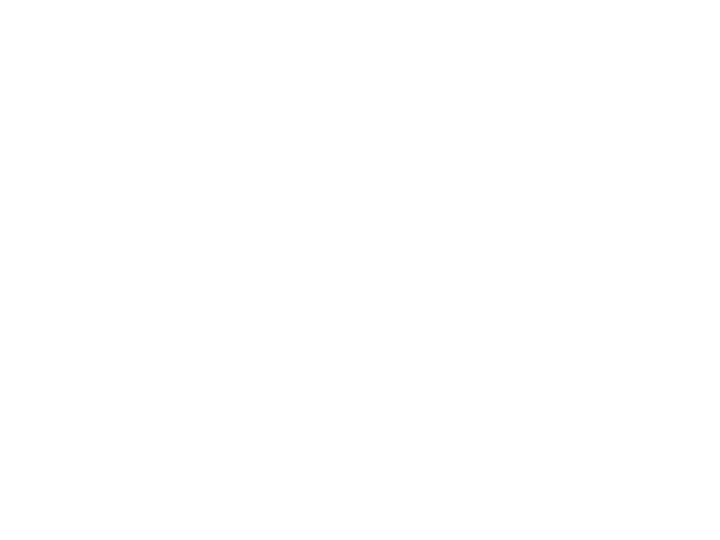

In [14]:
plt.close('all')
fig, ax = plt.subplots(1)
plt.title('PrcTotals/321-WQ-024.V vs time')
ax.plot(df['PrcTotals/321-WQ-024.V'])

# rotate and align the tick labels so they look better
fig.autofmt_xdate()

# use a more precise date string for the x axis locations in the
# toolbar
import matplotlib.dates as mdates
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
#plt.title('fig.autofmt_xdate fixes the labels')

In [15]:
#from fancyimpute import KNN
## X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN

# Use 3 nearest rows which have a feature to fill in each row's missing features
#X_filled_knn = KNN(k=3).complete(X_incomplete)

d. Challenge question (optional):   
Impute all other missing sensor values using a more robust technique   
(including but not limited to interpolation or kNN imputation).   
What are the advantages & disadvantages of your chosen imputation technique? 
---------------
Notes: col 'AS01-ScanTime/OB82T2.V' has 285 str values which count as NaN values col 'ACP:P:C2 TT Control/LaMvX_DB.PV_TipMv' has 2 float values which count as NaN values

In [16]:
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
#summaries missing sensor values in all columns
print ( "%45s %10s %10s" % ("Column Name", "#Non NAN", "Count NAN") )
count = 0
count
for colName in list(df):
    #print (colName, df[colName].count(), df.shape[0]-df[colName].count())
    df[colName] = pd.to_numeric(df[colName], errors='coerce')
    if df.shape[0]-df[colName].count()!=0 and df.shape[0]-df[colName].interpolate().count()!=0:
        df[colName] = pd.to_numeric(df[colName], errors='coerce').interpolate()
        print ("at count=", count, df[pd.isnull(df[colName])])
        print ( "%45s %10d %10d" % (colName, df[colName].count(), df.shape[0]-df[colName].count() ))
        print ("=========== ")
        print ("type(df[colName][0]):", type(df[colName][0]), ", type(df[colName]):", type(df[colName]))
        print ("-------------------------------------------------------------------")
        count += 1
        break
    
print ("# rows NOT fixed by interpolation :", count)

                                  Column Name   #Non NAN  Count NAN
at count= 0                      Utilities_Shutdown/USD1.Q  \
TimeStamp                                        
2013-01-02 10:11:30                        NaN   

                     ACP:P:C2$T$Control/322-PSL-100_DB.Q  mould_matte_SiO2  \
TimeStamp                                                                    
2013-01-02 10:11:30                                  NaN               NaN   

                     PrcCtl_Coal/Rd_Coal_PV1.V  \
TimeStamp                                        
2013-01-02 10:11:30                        NaN   

                     AS01_DATA_FROM_AS05/377-PIT-002_Lo.Q  \
TimeStamp                                                   
2013-01-02 10:11:30                             -0.410156   

                     ACP:P:C2$Matte$Tap$2/322-HS-628_DB.Q  322-PIT-105/PV.V  \
TimeStamp                                                                     
2013-01-02 10:11:30                      

In [17]:
print (df['Utilities_Shutdown/USD1.Q'].shape)
print (list(df)[0])
print (df['Utilities_Shutdown/USD1.Q'][58455])
print (type(df['Utilities_Shutdown/USD1.Q'][58455]) )
print ("# of Nan Values=", df['Utilities_Shutdown/USD1.Q'].shape[0] - df['Utilities_Shutdown/USD1.Q'].count())
colName = 'Utilities_Shutdown/USD1.Q'
print ("isnull values: ", df[pd.isnull(df[colName])][colName])
df[pd.notnull(df[colName])][colName].mean()
df[colName].describe()

(58456,)
Utilities_Shutdown/USD1.Q
6142.679
<class 'numpy.float64'>
# of Nan Values= 1
isnull values:  TimeStamp
2013-01-02 10:11:30   NaN
Name: Utilities_Shutdown/USD1.Q, dtype: float64


count    58455.000000
mean      4211.300162
std       3467.871782
min          0.000000
25%          0.000000
50%       4942.770000
75%       7189.059000
max      14251.260000
Name: Utilities_Shutdown/USD1.Q, dtype: float64

In [18]:
print (type(df['AS01-ScanTime/OB82T2.V'][0]))
print (df['AS01-ScanTime/OB82T2.V'][0])
print (df.shape)

<class 'str'>
148.3796
(58456, 481)


In [19]:
nans = lambda df: df[df.isnull()]
nans(df['AS01-ScanTime/OB82T2.V'])

TimeStamp
2013-03-08 16:55:00    NaN
2013-03-08 17:13:30    NaN
2013-03-08 18:03:00    NaN
2013-03-08 18:21:30    NaN
2013-03-08 19:19:00    NaN
2013-03-08 19:32:30    NaN
2013-03-08 19:51:30    NaN
2013-03-08 19:59:30    NaN
2013-03-08 20:44:30    NaN
2013-03-08 21:17:00    NaN
2013-03-09 02:36:00    NaN
2013-03-09 02:49:30    NaN
2013-03-09 03:23:00    NaN
2013-03-09 03:56:30    NaN
2013-03-09 04:08:30    NaN
2013-03-09 04:09:00    NaN
2013-03-09 04:31:00    NaN
2013-03-09 05:36:00    NaN
2013-03-09 06:28:30    NaN
2013-03-09 06:58:00    NaN
2013-03-09 07:12:00    NaN
2013-03-09 07:23:00    NaN
2013-03-09 07:24:30    NaN
2013-03-09 07:55:00    NaN
2013-03-09 08:24:00    NaN
2013-03-09 09:01:30    NaN
2013-03-09 09:05:00    NaN
2013-03-09 09:41:00    NaN
2013-03-09 09:50:00    NaN
2013-03-09 09:51:30    NaN
                      ... 
2016-02-12 04:48:30    NaN
2016-02-12 04:51:00    NaN
2016-02-12 05:13:00    NaN
2016-02-12 05:15:00    NaN
2016-02-12 05:21:00    NaN
2016-02-12 06:38:0

cleanup NaN values - simple version.

In [20]:
#simple replace NaN values with mean.
tempMean = df['master_feed_setpoint'].mean()
print ("tempMean:", tempMean)
df['master_feed_setpoint'] = df['master_feed_setpoint'].fillna(tempMean)
print ("master_feed_setpoint : Number of NAN values", df.shape[0]-df['master_feed_setpoint'].count())

tempMean: 24.645129917520908
master_feed_setpoint : Number of NAN values 0


In [21]:
#simple replace NaN values with mean.
tempMean = df['master_feed_rate'].mean()
print ("tempMean:", tempMean, type(tempMean))
df['master_feed_rate'] = df['master_feed_rate'].fillna(tempMean)
print ("master_feed_rate : Number of NAN values", df.shape[0]-df['master_feed_rate'].count())

tempMean: 22.823854240375066 <class 'float'>
master_feed_rate : Number of NAN values 0


3. Visualisation:   
a. The target for the feed rate into the process (“master_feed_rate”) is 42 tons per hour.   
Create a graph that helps to determine if this is achieved.   

b. The value of “master_feed_setpoint” represents the set point of the master feed rate into the process.   
“master_feed_rate” represents the actual value of the feed rate. 


Explain graphically the relationship between these two sensors.   
How well does the actual value match its set point? 


startTime: 2013-01-02T10:11:30.000000000 <class 'numpy.datetime64'>
endTime: 2013-01-13T02:57:30.000000000 <class 'numpy.datetime64'>


<IPython.core.display.Javascript object>


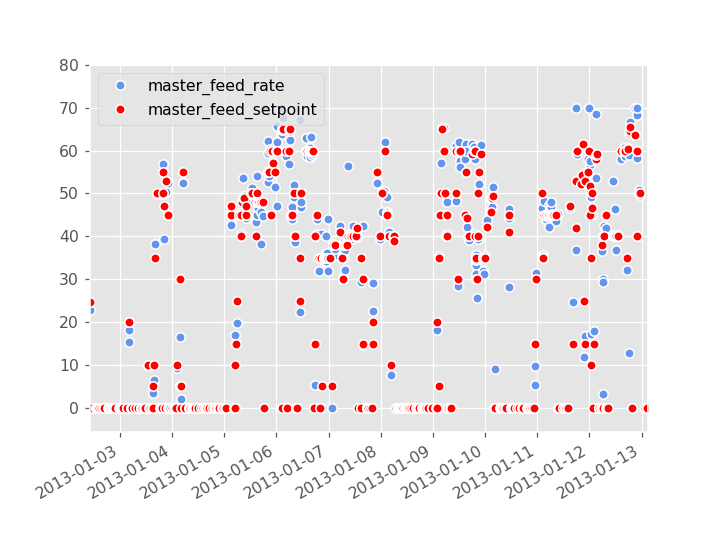

(-5.6388790000000002, 80.0)

In [22]:
plt.close('all')
temp = 500

startTime = df.index.values[0]
endTime = df.index.values[temp]
print ("startTime:", startTime, type(startTime))
print ("endTime:", endTime, type(endTime))

fig, ax = plt.subplots()
ax.plot_date(df.index.values[0:temp], df['master_feed_rate'][0:temp], markerfacecolor='CornflowerBlue', markeredgecolor='white', label='master_feed_rate')
ax.plot_date(df.index.values[0:temp], df['master_feed_setpoint'][0:temp], markerfacecolor='Red', markeredgecolor='white', label='master_feed_setpoint')
ax.legend(loc="upper left")
fig.autofmt_xdate()
ax.set_xlim([df.index.values[0], df.index.values[temp] ])
ax.set_ylim( [ min(df['master_feed_rate']), max(df['master_feed_rate']) ])

#todo: position legend outside plot area, this method should work.
#https://stackoverflow.com/questions/30413789/matplotlib-automatic-legend-outside-plot

Notes:  
- subsection of time period plotted to enable clarity.  
- overshooting and undershooting evident, needs analysis to clarify.  
- lag between 'master_feed_setpoint' and 'master_feed_rate' probably exists and is to be expected.  

In [37]:
#prepare Data for model building and fitting.
X = df['master_feed_rate'].as_matrix()              #input variables. for this test case using single input column
Y = df['master_feed_setpoint'].as_matrix()          #predicted column
print ("type(X):", type(X), X.shape)
print ("type(Y):", type(Y), Y.shape)


type(X): <class 'numpy.ndarray'> (58456,)
type(Y): <class 'numpy.ndarray'> (58456,)


In [36]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
# feed the linear regression with the train data to obtain a model.
X = X.reshape(-1, 1)
regr.fit(X, Y)
# The mean squared error
print("Mean squared error: %.2f" % np.mean((regr.predict(X) - Y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X, Y))


Mean squared error: 66.02
Variance score: 0.86
